<a href="https://colab.research.google.com/github/leeebs/bike_forecasting/blob/main/%EB%8C%80%EC%97%AC%EB%9F%89_%EC%98%88%EC%B8%A1%EC%9D%98_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from pandas.plotting import register_matplotlib_converters
from pylab import rcParams
from matplotlib import rc 

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.Data load

In [ ]:
input_file = '/content/drive/My Drive/datacam/bike/'

allFile_list = sorted(glob.glob(os.path.join(input_file, 'rent_data_2020_*.csv')))
print(allFile_list)

allData = []

for file in allFile_list:
  df = pd.read_csv(file, encoding='cp949')
  allData.append(df)

['/content/drive/My Drive/datacam/bike/rent_data_2020_01.csv', '/content/drive/My Drive/datacam/bike/rent_data_2020_02.csv', '/content/drive/My Drive/datacam/bike/rent_data_2020_03.csv', '/content/drive/My Drive/datacam/bike/rent_data_2020_04.csv', '/content/drive/My Drive/datacam/bike/rent_data_2020_05.csv', '/content/drive/My Drive/datacam/bike/rent_data_2020_06.csv', '/content/drive/My Drive/datacam/bike/rent_data_2020_07.csv', '/content/drive/My Drive/datacam/bike/rent_data_2020_08.csv', '/content/drive/My Drive/datacam/bike/rent_data_2020_09.csv', '/content/drive/My Drive/datacam/bike/rent_data_2020_10.csv', '/content/drive/My Drive/datacam/bike/rent_data_2020_11.csv', '/content/drive/My Drive/datacam/bike/rent_data_2020_12.csv']


In [ ]:
dataCombine = pd.concat(allData, axis=0)
bike = dataCombine
bike

,보관소명,년,월,일,요일,시간,대여량,기온,강수,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),총유입인구,총생활인구수,지하철_하차인원,구
0,(구)신한은행 중랑교지점,2020,1,1,수,0,0,-2.2,0.1,31.0,16.0,76727.0,384600.6820,0.0,중랑구
1,(구)신한은행 중랑교지점,2020,1,1,수,1,0,-5.2,0.0,31.0,16.0,74678.0,386599.3398,0.0,중랑구
2,(구)신한은행 중랑교지점,2020,1,1,수,2,0,-5.1,0.0,31.0,16.0,73718.0,388041.4154,0.0,중랑구
3,(구)신한은행 중랑교지점,2020,1,1,수,3,0,-5.3,0.0,31.0,16.0,73376.0,388881.0968,0.0,중랑구
4,(구)신한은행 중랑교지점,2020,1,1,수,4,0,-4.8,0.0,31.0,16.0,73378.0,388602.5135,0.0,중랑구
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1491691,힐스테이트에코,2020,12,31,목,19,2,-6.2,0.0,27.0,10.0,156311.0,534962.2667,0.0,강서구
1491692,힐스테이트에코,2020,12,31,목,20,0,-6.5,0.0,27.0,10.0,152987.0,539474.7866,0.0,강서구
1491693,힐스테이트에코,2020,12,31,목,21,3,-6.2,0.0,27.0,10.0,147288.0,542663.5689,0.0,강서구
1491694,힐스테이트에코,2020,12,31,목,22,1,-6.4,0.0,27.0,10.0,144520.0,544189.3726,0.0,강서구


## 2.Preprocessing

In [ ]:
def convert_df(df):
  df1 = df.copy()
  df1['time'] = time_date(df1)
  df1 = df1.reindex(columns=['보관소명', '년', '월', '일', '요일', '시간', '기온', '강수', 
                          '미세먼지(㎍/㎥)', '초미세먼지(㎍/㎥)', '총유입인구', '총생활인구수', '지하철_하차인원', '대여량', 'time'])
  dummies_col = ['월', '일','요일']
  df1 = pd.get_dummies(df1, columns=dummies_col, drop_first=True)
  #df = df.join(pd.get_dummies(df['요일'], prefix="요일"))
  df1['예측대여량'] = df1['대여량'].shift(-1).fillna(0)
  rent_df = df1[['time', '대여량']]
  convert_df = df1.drop(['보관소명','년','time'], axis=1)
  return convert_df, rent_df

In [ ]:
def time_date(df):
  
  time = []
  length = len(df['보관소명'])

  for i in range(length):
    yyyy = df['년'][i]
    mm = df['월'][i]
    dd = df['일'][i]
    tt = df['시간'][i]
    time.append((datetime.datetime(yyyy,mm,dd,tt)).strftime('%Y-%m-%d %H:%M:%S'))

  return time

In [ ]:
dduk = bike[bike['보관소명'] == '뚝섬유원지역 1번출구 앞']
dduk.reset_index(inplace=True,drop=True)
dduk, rent_df = convert_df(dduk)

In [ ]:
df = dduk

In [ ]:
df.head()

,시간,기온,강수,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),총유입인구,총생활인구수,지하철_하차인원,대여량,월_2,...,일_29,일_30,일_31,요일_목,요일_수,요일_월,요일_일,요일_토,요일_화,예측대여량
0,0,-2.2,0.1,28.0,16.0,88512.0,390059.2798,4.0,1,0,...,0,0,0,0,1,0,0,0,0,2.0
1,1,-4.9,0.0,28.0,16.0,82748.0,387849.1003,0.0,2,0,...,0,0,0,0,1,0,0,0,0,0.0
2,2,-4.5,0.0,28.0,16.0,80092.0,386270.2843,0.0,0,0,...,0,0,0,0,1,0,0,0,0,0.0
3,3,-4.7,0.0,28.0,16.0,78082.0,384653.2611,0.0,0,0,...,0,0,0,0,1,0,0,0,0,0.0
4,4,-4.8,0.0,28.0,16.0,77158.0,383800.3134,0.0,0,0,...,0,0,0,0,1,0,0,0,0,1.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 57 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   시간          8784 non-null   int64  
 1   기온          8784 non-null   float64
 2   강수          8784 non-null   float64
 3   미세먼지(㎍/㎥)   8784 non-null   float64
 4   초미세먼지(㎍/㎥)  8784 non-null   float64
 5   총유입인구       8784 non-null   float64
 6   총생활인구수      8784 non-null   float64
 7   지하철_하차인원    8784 non-null   float64
 8   대여량         8784 non-null   int64  
 9   월_2         8784 non-null   uint8  
 10  월_3         8784 non-null   uint8  
 11  월_4         8784 non-null   uint8  
 12  월_5         8784 non-null   uint8  
 13  월_6         8784 non-null   uint8  
 14  월_7         8784 non-null   uint8  
 15  월_8         8784 non-null   uint8  
 16  월_9         8784 non-null   uint8  
 17  월_10        8784 non-null   uint8  
 18  월_11        8784 non-null   uint8  
 19  월_12        8784 non-null  

## 3.Dataset split

In [ ]:
train_size = int(len(df)*0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

7027 1757


## 4.Scaler

In [ ]:
df.columns

Index(['시간', '기온', '강수', '미세먼지(㎍/㎥)', '초미세먼지(㎍/㎥)', '총유입인구', '총생활인구수',
       '지하철_하차인원', '대여량', '월_2', '월_3', '월_4', '월_5', '월_6', '월_7', '월_8',
       '월_9', '월_10', '월_11', '월_12', '일_2', '일_3', '일_4', '일_5', '일_6', '일_7',
       '일_8', '일_9', '일_10', '일_11', '일_12', '일_13', '일_14', '일_15', '일_16',
       '일_17', '일_18', '일_19', '일_20', '일_21', '일_22', '일_23', '일_24', '일_25',
       '일_26', '일_27', '일_28', '일_29', '일_30', '일_31', '요일_목', '요일_수', '요일_월',
       '요일_일', '요일_토', '요일_화', '이전대여량'],
      dtype='object')

In [ ]:
f_columns = ['시간', '기온', '강수', '미세먼지(㎍/㎥)', '초미세먼지(㎍/㎥)', '총유입인구', '총생활인구수',
       '지하철_하차인원', '월_2', '월_3', '월_4', '월_5', '월_6', '월_7', '월_8',
       '월_9', '월_10', '월_11', '월_12', '일_2', '일_3', '일_4', '일_5', '일_6', '일_7',
       '일_8', '일_9', '일_10', '일_11', '일_12', '일_13', '일_14', '일_15', '일_16',
       '일_17', '일_18', '일_19', '일_20', '일_21', '일_22', '일_23', '일_24', '일_25',
       '일_26', '일_27', '일_28', '일_29', '일_30', '일_31', '요일_목', '요일_수', '요일_월',
       '요일_일', '요일_토', '요일_화', '대여량']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['예측대여량']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['예측대여량'] = cnt_transformer.transform(train[['예측대여량']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['예측대여량'] = cnt_transformer.transform(test[['예측대여량']])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [ ]:
def create_dataset(x, y, time_steps=24):
  xs, ys = [], []
  for i in range(len(x) - time_steps):
    v = x.iloc[i:(i+time_steps)].values
    xs.append(v)
    ys.append(y.iloc[i+time_steps])
  return np.array(xs), np.array(ys)

In [ ]:
window_size = 24

#(samples, window_size, features)
x_train, y_train = create_dataset(train, train['예측대여량'], window_size)
x_test, y_test = create_dataset(test, test['예측대여량'], window_size)

print(x_train.shape, y_train.shape)

(7003, 24, 57) (7003,)


## 5.Modeling & Training

In [ ]:
inputs = Input(shape=(24,57,))
l1 = LSTM(1024, activation='tanh', return_sequences=True)(inputs)
l4 = LSTM(128, activation='relu')(l1)
drop = Dropout(0.3)(l4)
dense = Dense(64, activation='relu')(drop)
dense = Dense(32, activation='relu')(dense)
dense = Dense(32, activation='relu')(dense)
outputs = Dense(1)(dense)

model3 = Model(inputs, outputs)

model3.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 24, 57)]          0         
                                                                 
 lstm_6 (LSTM)               (None, 24, 1024)          4431872   
                                                                 
 lstm_7 (LSTM)               (None, 128)               590336    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 32)                1056

In [ ]:
model3.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
data_path = '/content/drive/My Drive/datacam'

earlystopping = EarlyStopping(monitor='val_loss', patience=20)
filename = os.path.join(data_path, 'rent_checkpointer1.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weight_only = True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)


history = model3.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    shuffle=False,
                    epochs=200,
                    batch_size=64,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
110/110 [==============================] - ETA: 0s - loss: 0.2683 - mean_absolute_error: 0.3026
Epoch 1: val_loss improved from inf to 0.14904, saving model to /content/drive/My Drive/datacam/rent_checkpointer1.ckpt


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/rent_checkpointer1.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/rent_checkpointer1.ckpt/assets


110/110 [==============================] - 11s 98ms/step - loss: 0.2683 - mean_absolute_error: 0.3026 - val_loss: 0.1490 - val_mean_absolute_error: 0.2469
Epoch 2/200
109/110 [============================>.] - ETA: 0s - loss: 0.2607 - mean_absolute_error: 0.3027
Epoch 2: val_loss improved from 0.14904 to 0.14449, saving model to /content/drive/My Drive/datacam/rent_checkpointer1.ckpt


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/rent_checkpointer1.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/rent_checkpointer1.ckpt/assets


110/110 [==============================] - 10s 93ms/step - loss: 0.2611 - mean_absolute_error: 0.3031 - val_loss: 0.1445 - val_mean_absolute_error: 0.2530
Epoch 3/200
110/110 [==============================] - ETA: 0s - loss: 0.2557 - mean_absolute_error: 0.3048
Epoch 3: val_loss did not improve from 0.14449
110/110 [==============================] - 5s 47ms/step - loss: 0.2557 - mean_absolute_error: 0.3048 - val_loss: 0.1558 - val_mean_absolute_error: 0.2585
Epoch 4/200
110/110 [==============================] - ETA: 0s - loss: 0.3426 - mean_absolute_error: 0.3287
Epoch 4: val_loss improved from 0.14449 to 0.13502, saving model to /content/drive/My Drive/datacam/rent_checkpointer1.ckpt


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/rent_checkpointer1.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/rent_checkpointer1.ckpt/assets


110/110 [==============================] - 11s 99ms/step - loss: 0.3426 - mean_absolute_error: 0.3287 - val_loss: 0.1350 - val_mean_absolute_error: 0.2543
Epoch 5/200
110/110 [==============================] - ETA: 0s - loss: 0.2776 - mean_absolute_error: 0.3160
Epoch 5: val_loss improved from 0.13502 to 0.13288, saving model to /content/drive/My Drive/datacam/rent_checkpointer1.ckpt


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/rent_checkpointer1.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/rent_checkpointer1.ckpt/assets


110/110 [==============================] - 11s 98ms/step - loss: 0.2776 - mean_absolute_error: 0.3160 - val_loss: 0.1329 - val_mean_absolute_error: 0.2472
Epoch 6/200
109/110 [============================>.] - ETA: 0s - loss: 0.2545 - mean_absolute_error: 0.3017
Epoch 6: val_loss did not improve from 0.13288
110/110 [==============================] - 5s 47ms/step - loss: 0.2545 - mean_absolute_error: 0.3020 - val_loss: 0.1514 - val_mean_absolute_error: 0.2571
Epoch 7/200
110/110 [==============================] - ETA: 0s - loss: 0.2698 - mean_absolute_error: 0.3075
Epoch 7: val_loss did not improve from 0.13288
110/110 [==============================] - 5s 47ms/step - loss: 0.2698 - mean_absolute_error: 0.3075 - val_loss: 0.1933 - val_mean_absolute_error: 0.2961
Epoch 8/200
110/110 [==============================] - ETA: 0s - loss: 0.3110 - mean_absolute_error: 0.3185
Epoch 8: val_loss did not improve from 0.13288
110/110 [==============================] - 5s 47ms/step - loss: 0.3110 -

INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/rent_checkpointer1.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/rent_checkpointer1.ckpt/assets


110/110 [==============================] - 11s 97ms/step - loss: 0.2051 - mean_absolute_error: 0.2776 - val_loss: 0.1279 - val_mean_absolute_error: 0.2364
Epoch 17/200
109/110 [============================>.] - ETA: 0s - loss: 0.1757 - mean_absolute_error: 0.2615
Epoch 17: val_loss did not improve from 0.12792
110/110 [==============================] - 5s 49ms/step - loss: 0.1755 - mean_absolute_error: 0.2616 - val_loss: 0.2387 - val_mean_absolute_error: 0.3093
Epoch 18/200
109/110 [============================>.] - ETA: 0s - loss: 0.1724 - mean_absolute_error: 0.2569
Epoch 18: val_loss did not improve from 0.12792
110/110 [==============================] - 5s 49ms/step - loss: 0.1722 - mean_absolute_error: 0.2567 - val_loss: 0.1682 - val_mean_absolute_error: 0.2457
Epoch 19/200
109/110 [============================>.] - ETA: 0s - loss: 0.2019 - mean_absolute_error: 0.2706
Epoch 19: val_loss did not improve from 0.12792
110/110 [==============================] - 5s 49ms/step - loss: 0.

In [ ]:
data_path = '/content/drive/My Drive/datacam'

earlystopping = EarlyStopping(monitor='val_loss', patience=20)
filename = os.path.join(data_path, 'rent_checkpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weight_only = True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)


history = model.fit(x_train, y_train,
                    validation_split=0.1,
                    shuffle=True,
                    epochs=200,
                    batch_size=32,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
132/132 [==============================] - 7s 38ms/step - loss: 1.2305 - mean_absolute_error: 0.6318 - val_loss: 0.5031 - val_mean_absolute_error: 0.4621

Epoch 00001: val_loss improved from inf to 0.50311, saving model to /content/drive/My Drive/datacam/checkpointer.ckpt


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/checkpointer.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/checkpointer.ckpt/assets


Epoch 2/200
132/132 [==============================] - 4s 34ms/step - loss: 0.5352 - mean_absolute_error: 0.4110 - val_loss: 0.3917 - val_mean_absolute_error: 0.4224

Epoch 00002: val_loss improved from 0.50311 to 0.39172, saving model to /content/drive/My Drive/datacam/checkpointer.ckpt


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/checkpointer.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/checkpointer.ckpt/assets


Epoch 3/200
132/132 [==============================] - 4s 34ms/step - loss: 0.4349 - mean_absolute_error: 0.3757 - val_loss: 0.4142 - val_mean_absolute_error: 0.4320

Epoch 00003: val_loss did not improve from 0.39172
Epoch 4/200
132/132 [==============================] - 5s 34ms/step - loss: 0.3830 - mean_absolute_error: 0.3644 - val_loss: 0.3785 - val_mean_absolute_error: 0.4115

Epoch 00004: val_loss improved from 0.39172 to 0.37849, saving model to /content/drive/My Drive/datacam/checkpointer.ckpt


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/checkpointer.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/checkpointer.ckpt/assets


Epoch 5/200
132/132 [==============================] - 4s 33ms/step - loss: 0.3420 - mean_absolute_error: 0.3479 - val_loss: 0.3809 - val_mean_absolute_error: 0.4176

Epoch 00005: val_loss did not improve from 0.37849
Epoch 6/200
132/132 [==============================] - 4s 34ms/step - loss: 0.3231 - mean_absolute_error: 0.3374 - val_loss: 0.3923 - val_mean_absolute_error: 0.4075

Epoch 00006: val_loss did not improve from 0.37849
Epoch 7/200
132/132 [==============================] - 4s 34ms/step - loss: 0.2974 - mean_absolute_error: 0.3331 - val_loss: 0.4536 - val_mean_absolute_error: 0.4285

Epoch 00007: val_loss did not improve from 0.37849
Epoch 8/200
132/132 [==============================] - 4s 34ms/step - loss: 0.2901 - mean_absolute_error: 0.3227 - val_loss: 0.4221 - val_mean_absolute_error: 0.4097

Epoch 00008: val_loss did not improve from 0.37849
Epoch 9/200
132/132 [==============================] - 4s 33ms/step - loss: 0.2894 - mean_absolute_error: 0.3228 - val_loss: 0.4

INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/checkpointer.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/checkpointer.ckpt/assets


Epoch 13/200
132/132 [==============================] - 4s 33ms/step - loss: 0.2538 - mean_absolute_error: 0.3082 - val_loss: 0.3552 - val_mean_absolute_error: 0.3813

Epoch 00013: val_loss improved from 0.37022 to 0.35518, saving model to /content/drive/My Drive/datacam/checkpointer.ckpt


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/checkpointer.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/checkpointer.ckpt/assets


Epoch 14/200
132/132 [==============================] - 4s 34ms/step - loss: 0.2542 - mean_absolute_error: 0.3048 - val_loss: 0.3557 - val_mean_absolute_error: 0.3894

Epoch 00014: val_loss did not improve from 0.35518
Epoch 15/200
132/132 [==============================] - 4s 33ms/step - loss: 0.2450 - mean_absolute_error: 0.3049 - val_loss: 0.3361 - val_mean_absolute_error: 0.3671

Epoch 00015: val_loss improved from 0.35518 to 0.33605, saving model to /content/drive/My Drive/datacam/checkpointer.ckpt


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/checkpointer.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/checkpointer.ckpt/assets


Epoch 16/200
132/132 [==============================] - 4s 34ms/step - loss: 0.2419 - mean_absolute_error: 0.3012 - val_loss: 0.3509 - val_mean_absolute_error: 0.3833

Epoch 00016: val_loss did not improve from 0.33605
Epoch 17/200
132/132 [==============================] - 4s 33ms/step - loss: 0.2434 - mean_absolute_error: 0.3033 - val_loss: 0.3862 - val_mean_absolute_error: 0.3883

Epoch 00017: val_loss did not improve from 0.33605
Epoch 18/200
132/132 [==============================] - 4s 33ms/step - loss: 0.2256 - mean_absolute_error: 0.2952 - val_loss: 0.3463 - val_mean_absolute_error: 0.3847

Epoch 00018: val_loss did not improve from 0.33605
Epoch 19/200
132/132 [==============================] - 4s 34ms/step - loss: 0.2242 - mean_absolute_error: 0.2916 - val_loss: 0.3562 - val_mean_absolute_error: 0.3805

Epoch 00019: val_loss did not improve from 0.33605
Epoch 20/200
132/132 [==============================] - 4s 33ms/step - loss: 0.2219 - mean_absolute_error: 0.2901 - val_loss

## 6.Visualization

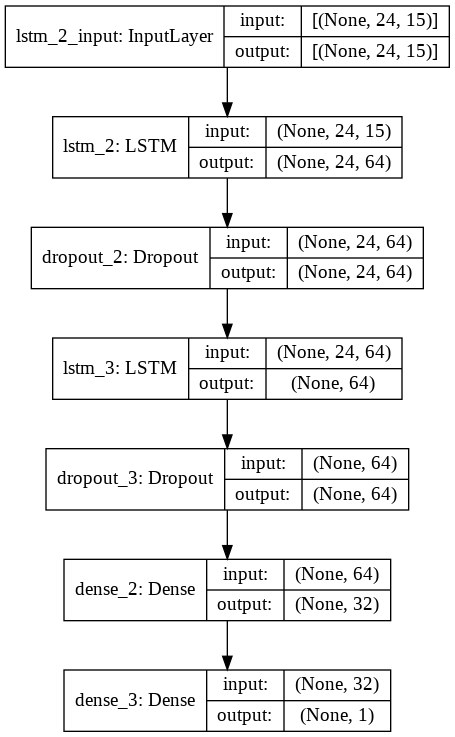

In [ ]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

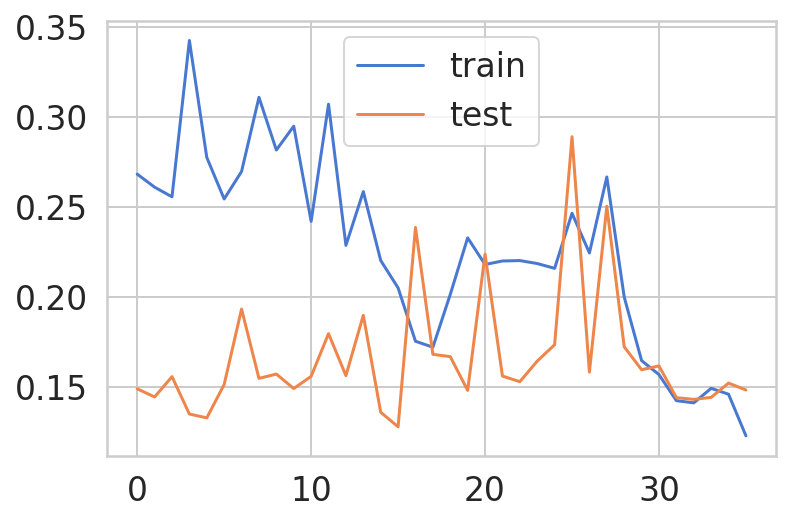

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
model3.load_weights(filename)
y_pred = model3.predict(x_test)

In [ ]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)
#pred_inv = cnt_transformer.inverse_transform(pred)

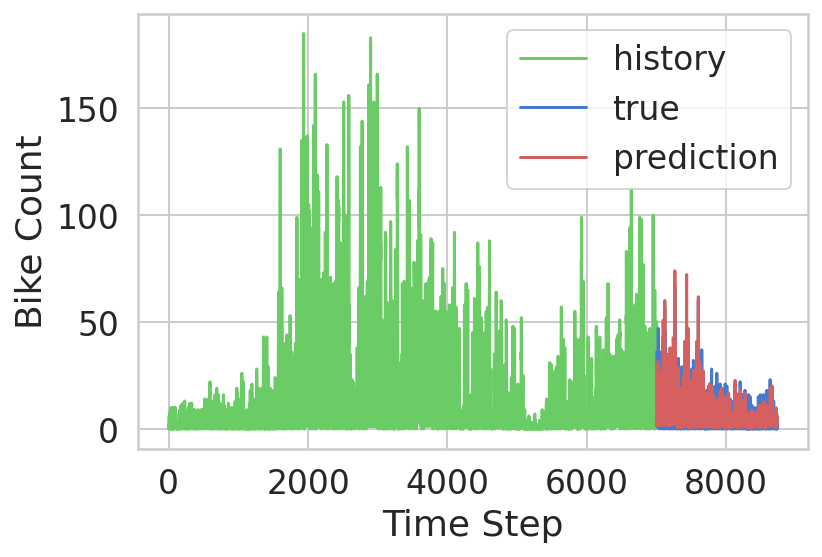

In [ ]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

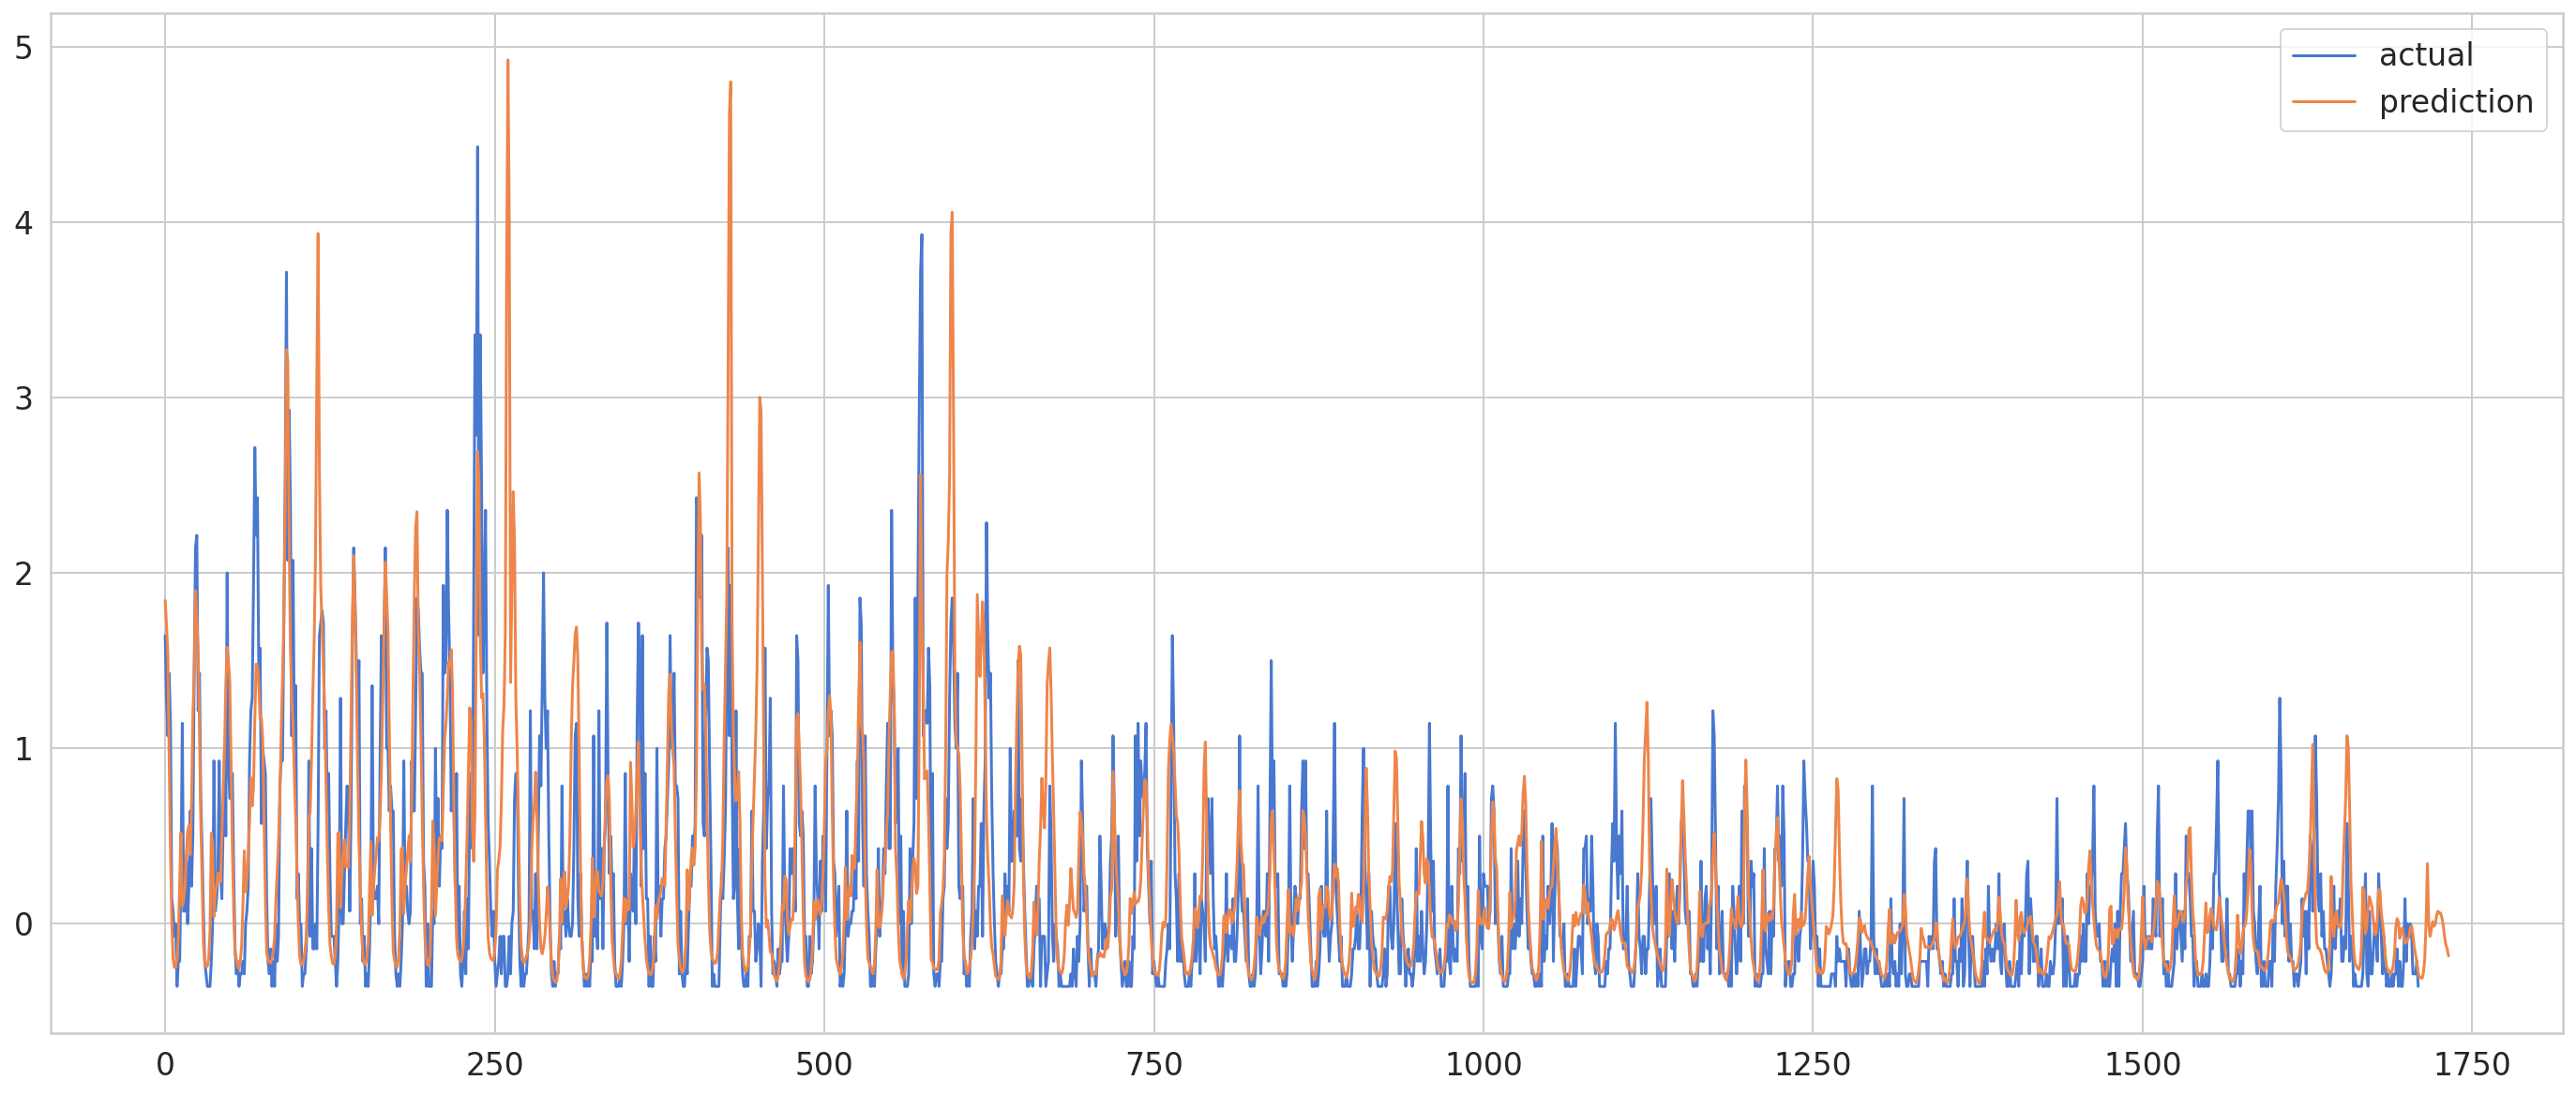

In [ ]:
plt.figure(figsize=(24, 10))
plt.plot(np.asarray(y_test)[23:], label='actual')
plt.plot(y_pred[:], label='prediction')
plt.legend()
plt.show()

In [ ]:
print(mean_absolute_error(y_test_inv.reshape(-1), y_pred_inv.reshape(-1)))

3.3099035237197305
